In [39]:
import numpy as np
from matplotlib import pyplot as plt
import random

# Input Data

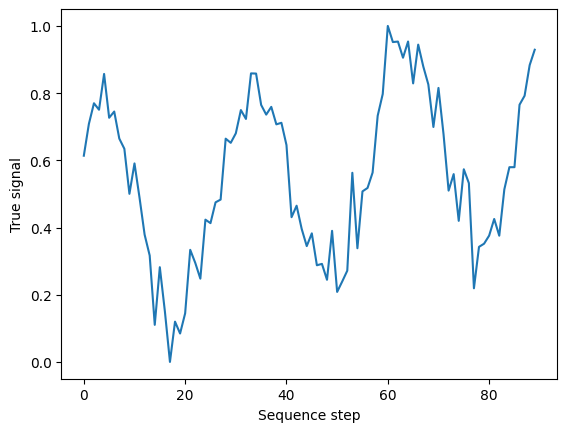

In [40]:
sample_count = 64
vals_per_sample = 90

mean_drift = 0.01
drift_sd = 0.001
sin_coeff = 12
noise_sd = 0.1

input_signals = []

for i in range(sample_count):
    # Choosing random degree to begin sample from
    start_deg = random.randint(0, 359) 
    
    current_signal = np.zeros(vals_per_sample)
    for j in range(vals_per_sample):
        
        current_deg = start_deg + j
        
        #Raw sine wave stretched by coefficient + noise + drift
        current_signal[j] = np.sin(np.radians(sin_coeff * current_deg)) \
                       + np.random.normal(0,noise_sd) \
                       + current_deg * np.random.normal(mean_drift,drift_sd)
        
    #Normalisation
    current_signal = (current_signal - np.min(current_signal)) / (np.max(current_signal) - np.min(current_signal)) 
    
    input_signals.append(current_signal)
        
plt.xlabel("Sequence step")
plt.ylabel("True signal")
plt.plot(np.arange(vals_per_sample),input_signals[0])

# Model

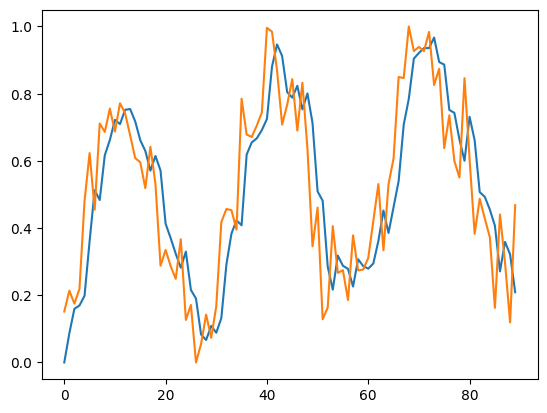

In [45]:
import numpy as np
from numpy.random import randn

# Modified from https://github.com/KTAswathi/IPB_2023/blob/main/IPB_lab3_BPTT.ipynb
class PC_RNN:

    def __init__(self, output_size, hidden_size=64):
        # Weights
        self.Wr = randn(hidden_size, hidden_size) / 1000
        self.Wo = randn(output_size, hidden_size) / 1000
        self.Wfeedback = randn(hidden_size, output_size) / 1000
        self.h_init =  np.random.normal(0,0.00001,(self.Wr.shape[0], 1))
    
    def predictive_code(self, pred_weight, lr, input_signals):

        h = self.h_init
        
        self.last_pred = { 0: h }

        outputs = []
        loss = []
        pred_loss = []

        # Step through sequence timesteps
        for i, x_true in enumerate(input_signals):

            # Compute hidden state based on previous state
            h = h + self.Wr @ np.tanh(h)
            
            # Compute output prediction and prediction error signal
            x_pred = self.Wo @ np.tanh(h)

            output_error = x_true - x_pred
            outputs.append(x_pred[0])

            # Compute prediction for hidden state
            h_pred = h + pred_weight * self.Wfeedback @ output_error # Might need to do something to dot these
            hidden_error = h_pred - h
            self.last_pred[i + 1] = h_pred

            # Update weights
            if i > 0:
                self.Wr = self.Wr + lr * hidden_error @ np.transpose(np.tanh(self.last_pred[i]))
            self.Wfeedback = self.Wfeedback + lr * np.tanh(h) @ np.transpose(output_error)
            self.Wo = self.Wo + lr * output_error @ np.transpose(np.tanh(h))
            
            h = h_pred

            loss.append(np.mean(np.abs(output_error)))
            pred_loss.append(np.mean(np.abs(hidden_error)))
            
        return outputs, np.mean(loss), np.mean(pred_loss)

rnn = PC_RNN(1,hidden_size=20)

avg_loss = []
avg_pred_loss = []

epochs = 20

for epoch in range(epochs):
    total_loss = 0
    total_pred_loss = 0
    for i in range(len(input_signals)):
        _, loss, pred_loss = rnn.predictive_code(0.2, 0.1, input_signals[i])
        total_loss += loss
        total_pred_loss += pred_loss
    avg_loss.append(total_loss/epochs)
    avg_pred_loss.append(total_pred_loss/epochs)
    
sequence, _, _ = rnn.predictive_code(0.2, 0.1, input_signals[2])

plt.plot(np.arange(90),sequence)
plt.plot(np.arange(90),input_signals[2])
plt.show()

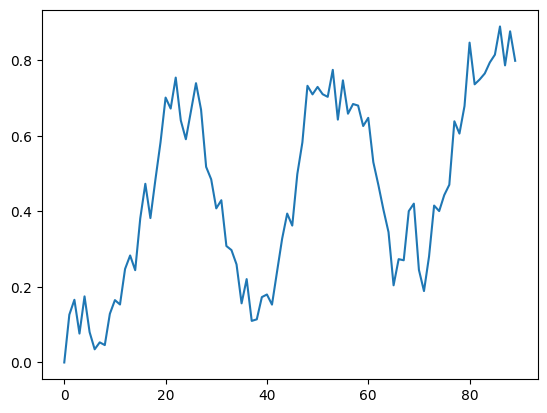

In [42]:
plt.plot(np.arange(90),sequence)

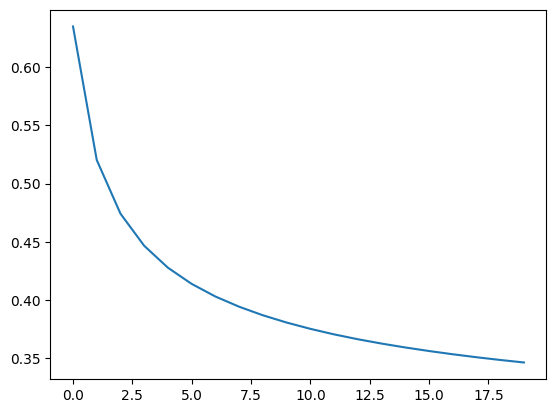

In [43]:
plt.plot(np.arange(epochs),avg_loss)

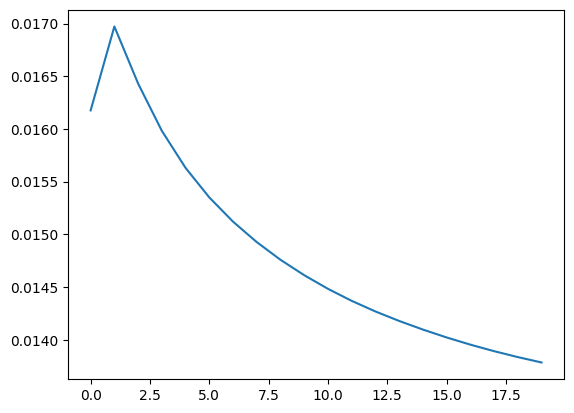

In [46]:
plt.plot(np.arange(epochs),avg_pred_loss)